In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lsst.sims.maf.db as db
from lsst.sims.maf.utils import m52snr
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.plots as plots

import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
from lsst.sims.utils import equatorialFromGalactic, hpid2RaDec, _healbin, healbin
from lsst.utils import getPackageDir
from mafContrib import TdePopMetric, generateTdePopSlicer, Tde_lc
import healpy as hp
import os

In [2]:
# Generate the slicer which puts 10,000 events at random spots on the sphere
slicer = generateTdePopSlicer(seed=42)

In [3]:
runName = 'baseline_v1.5_10yrs' 
opsdb = db.OpsimDatabase(runName+'.db')
outDir = 'temp'
resultsDb = db.ResultsDb(outDir=outDir)

metric = TdePopMetric()
sql = ''
# Don't want to try and plot N individual points, 
plotDict = {'reduceFunc': np.sum, 'nside': 64}
plotFuncs = [plots.HealpixSkyMap()]
summaryMetrics=[metrics.MeanMetric(maskVal=0)]
bundle = metricBundles.MetricBundle(metric, slicer, sql, runName=runName,
                                    plotDict=plotDict, plotFuncs=plotFuncs,
                                    summaryMetrics=summaryMetrics)

Querying database SummaryAllProps with no constraint for columns ['fiveSigmaDepth', 'fieldRA', 'observationStartMJD', 'night', 'fieldDec', 'filter'].
Found 2224095 visits
Running:  ['baseline_v1_5_10yrs_TDEsPopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/Users/yoachim/git_repos/sims_maf/python/lsst/sims/maf/plots/plotHandler.py:518: UserWarning: Cannot plot object metric values with this plotter.
  warnings.warn('Cannot plot object metric values with this plotter.')


Plotting complete.


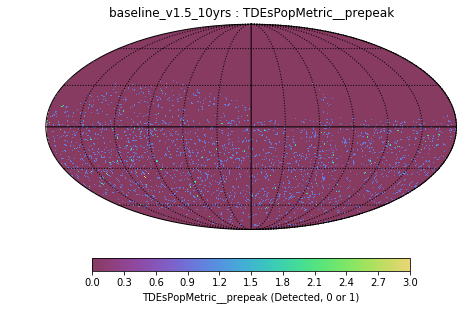

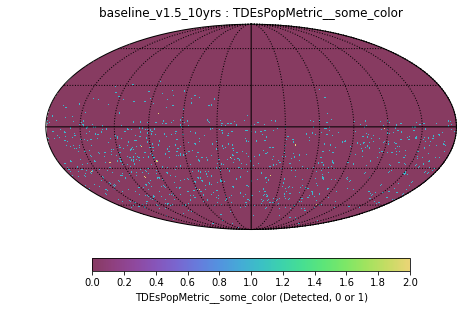

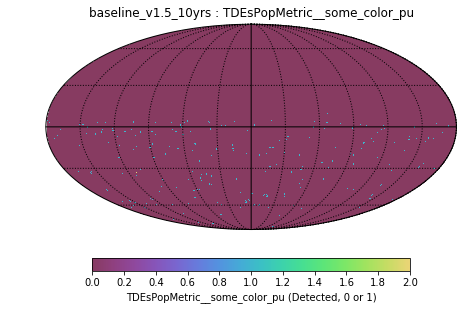

In [4]:
bd = metricBundles.makeBundlesDictFromList([bundle])
bgroup = metricBundles.MetricBundleGroup(bd, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()
bgroup.plotAll(closefigs=False)

In [5]:
# Let's see how we do.
for key in bd:
    print(key, bd[key].summaryValues)

baseline_v1_5_10yrs_TDEsPopMetric_USER {}
TDEsPopMetric__prepeak {'Mean': 0.2566}
TDEsPopMetric__some_color {'Mean': 0.0965}
TDEsPopMetric__some_color_pu {'Mean': 0.0214}


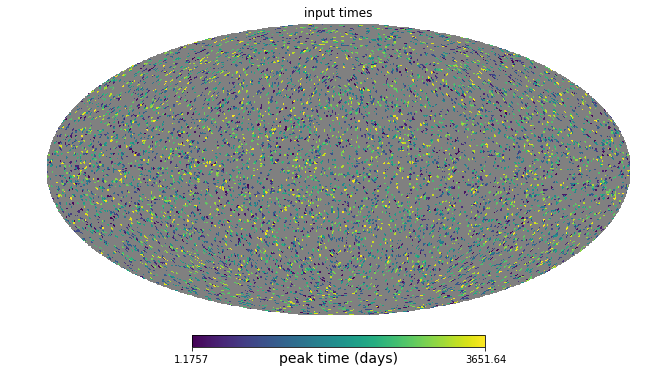

In [6]:
# Check that the positions and times look random
hp.mollview(_healbin(slicer.slicePoints['ra'], slicer.slicePoints['dec'], 
           slicer.slicePoints['peak_time'], 64, reduceFunc=np.mean), unit='peak time (days)',
           title='input times')

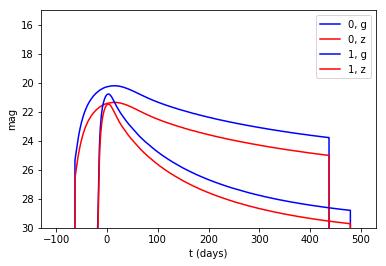

In [7]:
# let's plot up a few of the lightcurves
ivals=[0,1]

for i in ivals:
    t = np.arange(-100, 500)
    lc = metric.lightcurves.interp(t, 'g', lc_indx=slicer.slicePoints['file_indx'][i])
    plt.plot(t, lc, color='blue', label='%i, g' % i)
    lc = metric.lightcurves.interp(t, 'z', lc_indx=slicer.slicePoints['file_indx'][i])
    plt.plot(t, lc, color='red', label='%i, z' % i)
plt.ylim([30,15])
plt.xlabel('t (days)')
plt.ylabel('mag')
plt.legend()

In [8]:
# Let's see if there's a preference for which light curve was detected
indxes = np.unique(slicer.slicePoints['file_indx'])
for indx in indxes:
    in_indx = np.where(slicer.slicePoints['file_indx'] == indx)[0]
    n_total = in_indx.size
    detected = bd['TDEsPopMetric__prepeak'].metricValues[in_indx].data.sum()
    print('file indx %i and %f fraction recovered' % (indx, detected/n_total))

file indx 0 and 559.134239 fraction recovered
file indx 1 and 582.814086 fraction recovered
file indx 2 and 605.484427 fraction recovered
file indx 3 and 637.466231 fraction recovered
file indx 4 and 608.137145 fraction recovered
file indx 5 and 545.611450 fraction recovered
file indx 6 and 634.192399 fraction recovered
